In [10]:
from importlib import reload
import flymovie as fm
import cnn_models
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
from fpdf import FPDF
import random
import pickle
from pathlib import Path
import scipy.spatial
import scipy.ndimage as ndi
import tensorflow as tf
from importlib import reload
import scipy.ndimage as ndi
from skimage.measure import regionprops
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
im = fm.read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo17.czi', swapaxes=False)
fm.viewer(im, 5)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'gray', 'gray_r', '…

In [25]:
thresh = 25
nucs = []
sm = ndi.gaussian_filter(im, (2,5,5))
mask = np.where(sm >= thresh, 1, 0)
lmask, _ = ndi.label(mask)
regions = regionprops(lmask)
for n in range(0, len(regions)):
    centroid = [int(x) for x in regions[n].centroid]
    i, j = centroid[1:]
    start_i = i - 50
    end_i = i + 50
    start_j = j - 50
    end_j = j + 50
    if ((start_i >= 0) & (start_j >= 0) & (end_i <= lmask.shape[1]) & (end_j <= lmask.shape[2])):
        nucs.append(im[5:39, start_i:end_i, start_j:end_j])
        


In [141]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/checkpoint_final_8epochs_easytomedium_plus_8x99.9'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=8)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [161]:
def embed_list(ims, embedding):
    e = np.ndarray((0,256))
    for im in ims:
        im = im.astype('float32')
        # Dummy axis must be added in position 0.
        im = np.expand_dims(im, axis=-1)
        # Normalize 0-1.
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        im_e = embedding(im).numpy()
        e = np.vstack([e, im_e])
    return e


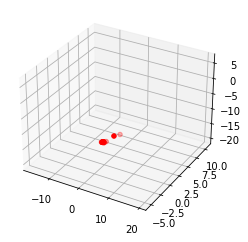

In [183]:
import sklearn.decomposition
def pca3d(e_base, e_test, alpha=1):
    combined = np.vstack((e_base, e_test))
    pca = sklearn.decomposition.PCA(n_components=3)
    pca.fit(e_base)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    tfm_base = pca.transform(e_base)
    ax.scatter(tfm_base[:,0], tfm_base[:,1], tfm_base[:,2], 
                    c="green", alpha=alpha)
    
    tfm_test = pca.transform(e_test)
    ax.scatter(tfm_test[:,0], tfm_test[:,1], tfm_test[:,2], 
                    c="red")

pca3d(embeddings_base, e, 0)

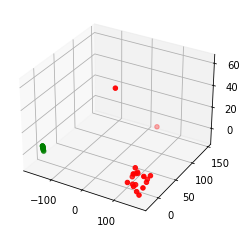

In [97]:
base_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/siamese_eval_datasets/iso_HLB_fluors/left'
embeddings_base, params_base = ev.embed_images(base_folder, embedding)
pca3d(embeddings_base, e)

In [142]:
from cnn_models.siamese_cnn import preprocess_image
def preprocess_image_py(file):
    [im,] = tf.py_function(preprocess_image,[file,],[tf.float32,])
    return im

def make_ds(folder):
    im_files = []
    for f in os.listdir(folder):
        if f[0] == '.':
            continue
        im_files.append(os.path.join(folder, f))
    
    dataset = tf.data.Dataset.from_tensor_slices(im_files)
    dataset = dataset.map(preprocess_image_py, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

ds = make_ds('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/siamese_eval_datasets/rpb1_wide_UTkaWAfT/left')

In [146]:
embeddings_base, params_base = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/8epochs_easytomedium_plus_8x99.9_left_embeddings.pkl')


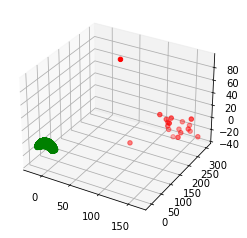

In [147]:
pca3d(embeddings_base, e)

Some ideas:
- Do some modifications to real data to make them look more like fake images (add noise, deconvolve, reconvolve)
- Train with a mix of real and fake data (real-real comparisons, fake-fake comparisons)
- Include some real-fake *similar* pairs hand-tuned to be similar according to moi.
-

In [ ]:
def save_list(l, outfolder):
    if not os.path.exists(outfolder):
        os.mkdir(outfolder)
    count = 1
    for arr in l:
        
        fake_id = 'aaa_'
        fake_params = [str(round(x, 2)) for x in np.random.random(9)]
        filepath = os.path.join(outfolder, fake_id + '_'.join(fake_params) + '.pkl')
        fm.save_pickle(arr, filepath)
        count += 1

save_list(nucs_mod, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/realnucs_mod')

In [218]:
nucs_mod = []
sigma = 100
for nuc in nucs:
    #nuc_mod = nuc + np.random.poisson(nuc)
    gaussian = np.random.normal(np.zeros_like(nuc), scale=sigma)
    nucs_mod.append(nuc + gaussian)

save_list(nucs_mod, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/realnucs_mod')


In [223]:
e, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/realnucs_test', embedding)

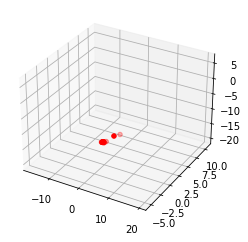

In [224]:
pca3d(embeddings_base, e, 0.0001)

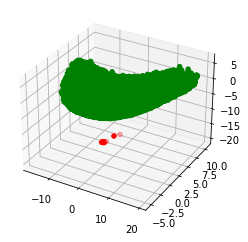

In [225]:
pca3d(embeddings_base, e, 1)

OK, it's all in the training data. There are basically two directions:

1) Make simulated images more similar to real images (eliminate peculiarities)
2) Add real images to training data

I think I should try both. Plan:

1) Modify simulations to remove artificial artifacts (circles in center, zero background, etc.)
2) Hand-tune some simulations to match real nuclei

Make training sets of like 5_000, do a handful of epochs, see if real images embed amidst fake ones.




In [263]:
def load_folder(folder):
    ims = []
    for f in os.listdir(folder):
        if f[0] == '.':
            continue
        im = fm.load_pickle(os.path.join(folder, f))
        ims.append(im)
    return ims

In [265]:
ims = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/fakesims_bigger_SJZCxOjT/left')
fake = np.array(ims)
real = np.array(nucs)
real = real * np.mean(fake) / np.mean(real)



In [274]:
fake_z = []
for im in fake:
    fake_z.append(im[:,15:-25,15:-25])

In [270]:
save_list(fake_z, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_wayoffcenter')

In [271]:
e_centered, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_center', embedding)
e_offcenter, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_offcenter', embedding)

In [293]:
from flymovie.simnuc import Sim
def make_imperfect_masks(dims=(34,100,100), nucrad_mean=45, nucrad_range=3, center_range=5, n=20):
    rs = np.random.RandomState()
    maskdims = (dims[0], dims[1] + (2 * center_range), dims[2] + (2 * center_range))
    masks = []
    for _ in range(n):
        nucrad_adj = rs.randint(-1 * nucrad_range, nucrad_range)
        i_adj = rs.randint(0, 2 * center_range)
        j_adj = rs.randint(0, 2 * center_range)
        mask = Sim.make_spherical_mask(maskdims[0], maskdims[1], maskdims[2], nucrad_mean + nucrad_adj)
        mask = mask[:, i_adj:(i_adj + dims[1]), j_adj:(j_adj + dims[2])]
        masks.append(mask)

    return masks

masks = make_imperfect_masks()

In [297]:
ims = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/fakesims_multimask_ekQsIzee/left')
fm.viewer(ims)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'gray', 'gray_r', '…

In [298]:
ims[0].shape

(34, 100, 100)

In [304]:
ims[slice(np.random.randint(0,10,2))]

TypeError: only integer scalar arrays can be converted to a scalar index

In [312]:
a = [ims[x] for x in np.random.randint(0,10, 4)]

In [313]:
a[0].shape

(34, 100, 100)

In [337]:
left = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/fakesims_multimask_aQuVBgcs/left')
right = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/fakesims_multimask_aQuVBgcs/right')

In [338]:
fm.viewer(left, 5)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'gray', 'gray_r', '…

In [339]:
fm.viewer(right, 5)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'gray', 'gray_r', '…

In [321]:
fm.viewer(nucs[:10], 5)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'gray', 'gray_r', '…

In [325]:
np.random.choice([[1],[2]], 2)

ValueError: a must be 1-dimensional

In [331]:
a, b, c = np.where(mask)
d = list(zip(a,b,c))

In [333]:
np.random.choice()

ValueError: a must be 1-dimensional

In [336]:
d[tuple(slice(tuple([2,4])))]

TypeError: 'slice' object is not iterable